In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

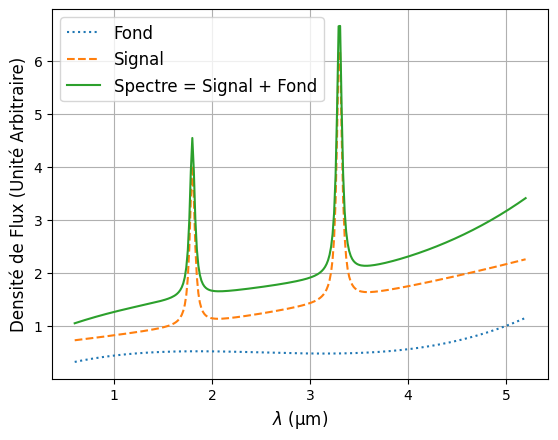

In [227]:
def polynome(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

def lorentz(x,x0,L,A):
    return A / (1 + (2*(x-x0)/L)**2)

def exp(x,T,c,A):
    return A*(np.exp(x/T)-c)

def gauss(X,FWHM):
    s = FWHM/2.355
    x,y = X
    return np.exp(-((y-y.max()/2)**2)/2/s**2)
    

x = np.linspace(0.6,5.2,300)
coeff_fond = [0.04,-0.3,0.7,0]
coeff_raie1 = [3.3,0.06,5]
coeff_raie2 = [1.8,0.06,3]
coeff_exp = [6,0.5,1.2]

fond = polynome(x,*coeff_fond)
dfond = np.random.normal(0,0.05,len(x))
signal = exp(x,*coeff_exp) + lorentz(x,*coeff_raie1) + lorentz(x,*coeff_raie2)
spectre = fond + signal
recorded_fond = fond + np.random.normal(0,0.05,len(x))
recorded_spectre = spectre + dfond

plt.figure()
#plt.plot(x,recorded_spectre,label="mesure",color='k',linewidth=0.5)
plt.plot(x,fond,label="Fond",linestyle="dotted")
plt.plot(x,signal,label="Signal",linestyle="dashed")
plt.plot(x,spectre,label="Spectre = Signal + Fond")
plt.grid()
plt.legend(fontsize=12)
plt.xlabel(r"$\lambda$ (µm)",fontsize=12)
plt.ylabel("Densité de Flux (Unité Arbitraire)",fontsize=12)
plt.show()

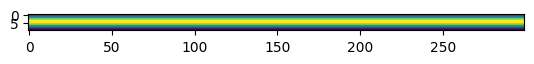

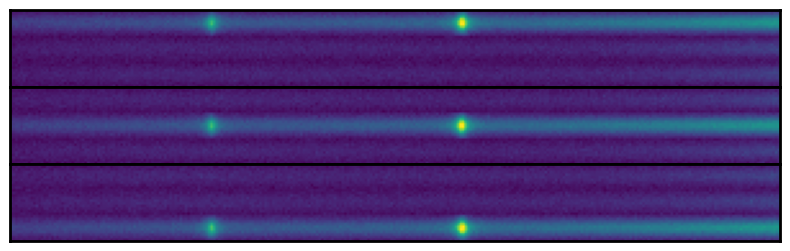

In [264]:
X = np.repeat(x[:,None],10,axis=1).T

YY,XX = np.indices(X.shape)

slit = gauss([XX,YY],6)
slits = np.concatenate([slit,slit,slit],axis=0)
slits5 = np.concatenate([slit,slit,slit,slit,slit],axis=0)

plt.figure()
plt.imshow(slit)


signal_2D = (exp(X,*coeff_exp) + lorentz(X,*coeff_raie1) + lorentz(X,*coeff_raie2) + polynome(X,*coeff_fond)) * slit
bkg = polynome(X,*coeff_fond) * slit + signal_2D/2000000

img0 = np.concatenate([signal_2D,bkg,bkg],axis=0)
img0 += np.random.normal(0,0.1,img0.shape)
img1 = np.concatenate([bkg,signal_2D,bkg],axis=0)
img1 += np.random.normal(0,0.1,img1.shape)
img2 = np.concatenate([bkg,bkg,signal_2D],axis=0)
img2 += np.random.normal(0,0.1,img2.shape)

lamb = np.concatenate([X,X,X],axis=0)

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10,3))
axes[0].imshow(img0)
axes[1].imshow(img1)
axes[2].imshow(img2)
plt.subplots_adjust(wspace=0, hspace=0)

# Add border around each subplot to delimit them
for ax in axes:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)  # Set the border width
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks

# Show the plot
plt.show()

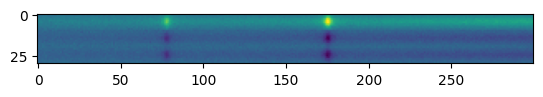

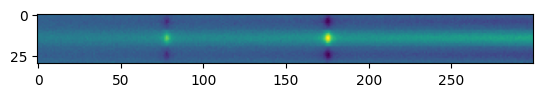

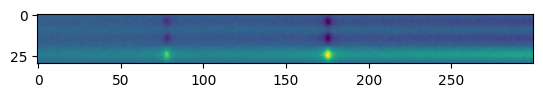

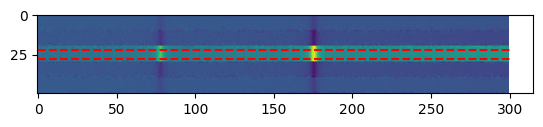

In [265]:
mast0 = img0 - (img1 + img2)/2
mast1 = img1 - (img0 + img2)/2
mast2 = img2 - (img1 + img0)/2


plt.figure()
plt.imshow(mast0)
plt.show()
plt.figure()
plt.imshow(mast1)
plt.show()
plt.figure()
plt.imshow(mast2)
plt.show()

mast0 = np.pad(mast0,([20,0],[0,0]))
mast1 = np.pad(mast1,([10,10],[0,0]))
mast2 = np.pad(mast2,([0,20],[0,0]))

mast = ((mast0+mast1+mast2)/3)/slits5

n = 3
yExtract = mast.shape[0]/2
extracted_mast = mast[round(yExtract-n):round(yExtract+n),:].mean(axis=0)

plt.figure()
plt.imshow(mast)
plt.hlines((yExtract-n,yExtract+n),0,mast.shape[1],color='r',linestyle="dashed")
plt.show()


In [266]:
def bin_data(X,Y,dY,delta):
    bins = np.arange(np.min(X), np.max(X) + delta, delta)
        
    # Digitize X data into bins
    bin_indices = np.digitize(X, bins)

    # Initialize lists to store the binned values
    binned_X = []
    binned_Y = []
    binned_dZ = []

    # Calculate means and uncertainties for each bin
    for i in range(1, len(bins)):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            X_bin = X[bin_mask]
            Y_bin = Y[bin_mask]
            dY_bin = dY[bin_mask]

            mean_X = np.mean(X_bin)
            mean_Y = np.mean(Y_bin)
            mean_dY = np.mean(dY_bin**2) + np.var(Y_bin) / len(Y_bin)
            mean_dY = np.sqrt(mean_dY)

            binned_X.append(mean_X)
            binned_Y.append(mean_Y)
            binned_dZ.append(mean_dY)

    # Convert lists to numpy arrays for plotting
    binned_X = np.array(binned_X)
    binned_Y = np.array(binned_Y)
    binned_dZ = np.array(binned_dZ)

    return binned_X, binned_Y, binned_dZ

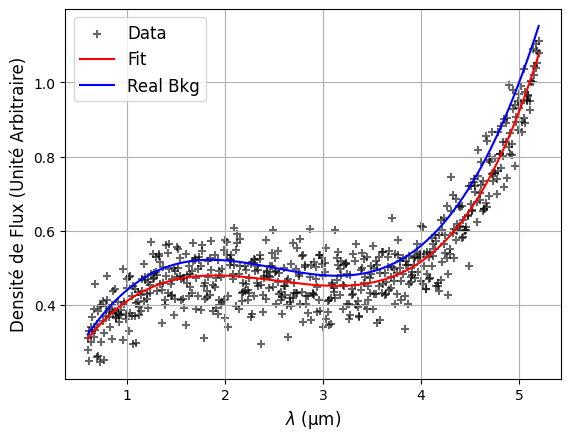

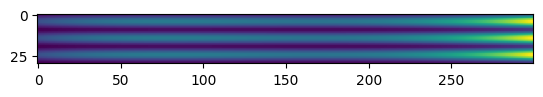

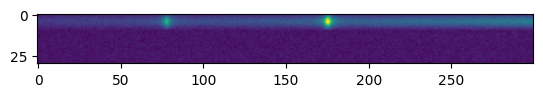

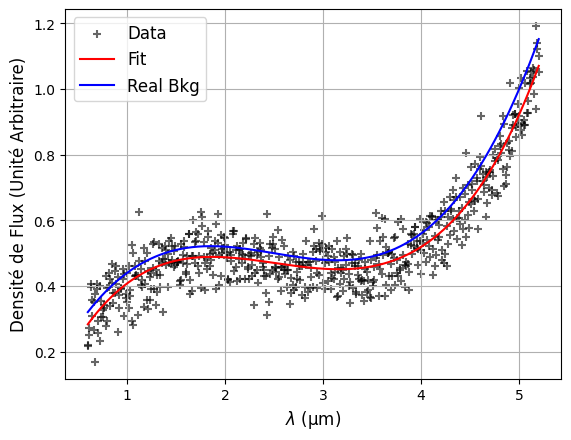

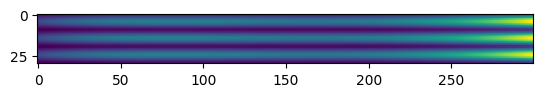

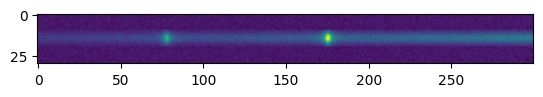

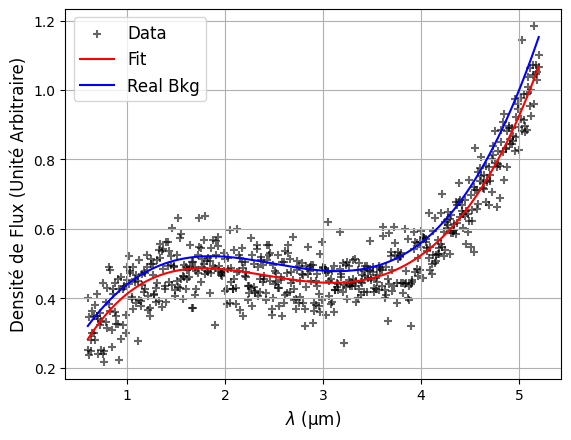

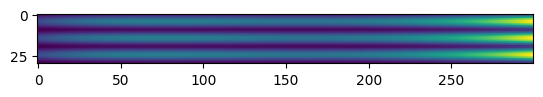

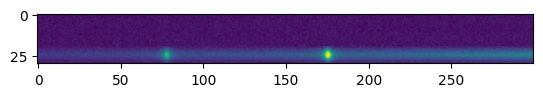

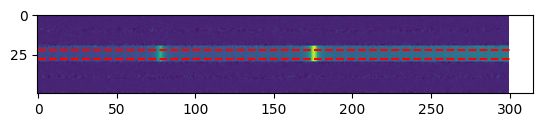

In [267]:
ximg = np.append(x,x)
indices = np.argsort(ximg)
ximg = ximg[indices]

n = img0.shape[0]
yExtract = [n/6.0,n/2.0,5*n/6.0]

custom_list = []

for i,img in enumerate([img0,img1,img2]):
    
    width = 1
    yimg = np.append(img[round(yExtract[i-1]-width):round(yExtract[i-1]+1+width)].mean(axis=0),
                  img[round(yExtract[i-2]-width):round(yExtract[i-2]+1+width)].mean(axis=0))
    yimg = yimg[indices]
    
    interp = UnivariateSpline(ximg, yimg, s=5, k=5)
    
    
    binned_X, binned_Y, binned_dZ = bin_data(ximg,yimg,np.zeros_like(yimg),0.1)
    
    plt.figure()
    plt.scatter(ximg,yimg,color='k',marker='+',alpha=0.6,label='Data')
    plt.plot(ximg,interp(ximg),color='r',label="Fit")
    plt.plot(x,fond,color="b",label='Real Bkg')
    #plt.plot(binned_X,binned_Y,color='orange',label="Mean Data")
    #plt.fill_between(binned_X,binned_Y - binned_dZ, binned_Y + binned_dZ, color='orange',alpha=0.5)
    plt.xlabel(r"$\lambda$ (µm)",fontsize=12)
    plt.ylabel("Densité de Flux (Unité Arbitraire)",fontsize=12)
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()
    
    background = interp(lamb) * slits
    
    plt.figure()
    plt.imshow(background)
    plt.show()
    
    custom = img - background
    
    custom_list.append(custom)
    
    plt.figure()
    plt.imshow(custom)
    plt.show()
    
custom0 = np.pad(custom_list[0],([20,0],[0,0]))
custom1 = np.pad(custom_list[1],([10,10],[0,0]))
custom2 = np.pad(custom_list[2],([0,20],[0,0]))

custom = ((custom0+custom1+custom2)/3)/slits5

n = 3
yExtract = custom.shape[0]/2
extracted_custom = custom[round(yExtract-n):round(yExtract+n),:].mean(axis=0)

plt.figure()
plt.imshow(custom)
plt.hlines((yExtract-n,yExtract+n),0,custom.shape[1],color='r',linestyle="dashed")
plt.show()


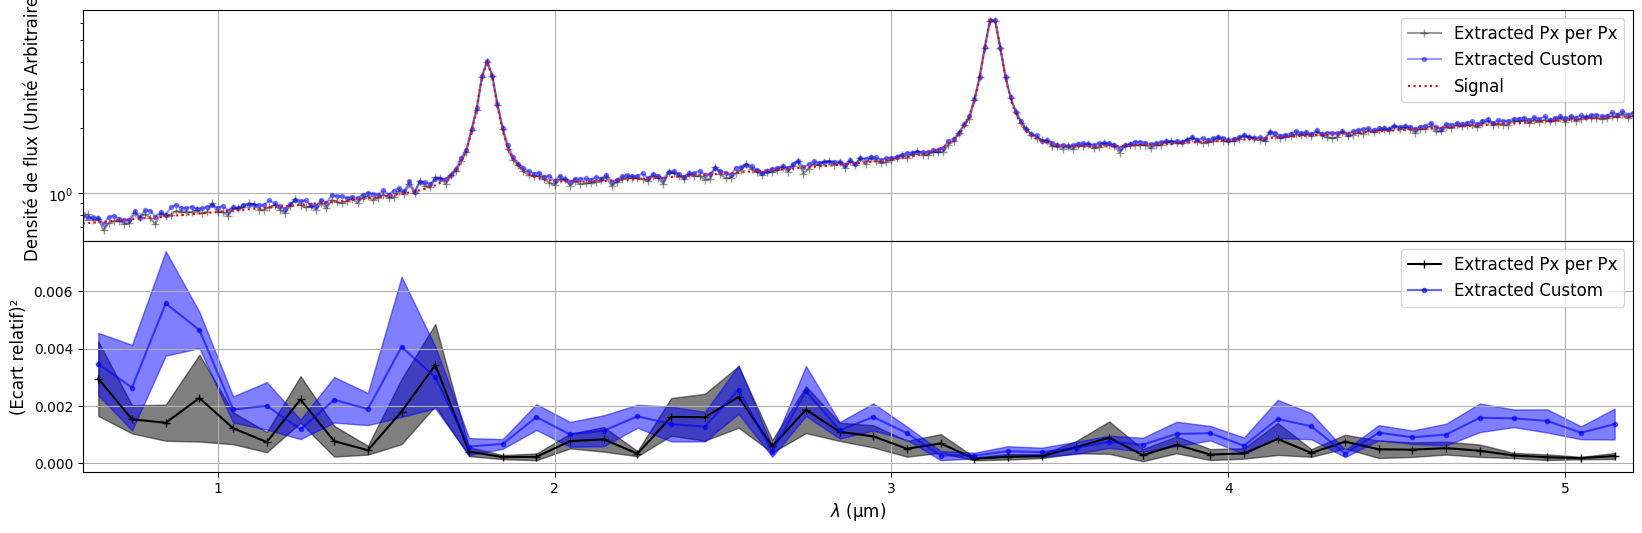

In [268]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,6))
axes[0].plot(x,extracted_mast,label='Extracted Px per Px',color="k",marker='+',alpha=0.4)
axes[0].plot(x,extracted_custom,label='Extracted Custom',color="b",marker=".",alpha=0.4)
axes[0].plot(x,signal,label="Signal",color="r",linestyle="dotted")
axes[0].legend(fontsize=12)
axes[0].grid(True)
axes[0].set_xlabel(r"$\lambda$ (µm)",fontsize=12)
axes[0].set_ylabel(r"Densité de flux (Unité Arbitraire)",fontsize=12)
axes[0].set_yscale("log")
axes[0].set_xlim(x.min(),x.max())


binx,biny,bindy = bin_data(x,(signal-extracted_mast)**2/signal**2,np.zeros_like(x),0.1)

axes[1].plot(binx,biny,label='Extracted Px per Px',color="k",marker="+")
axes[1].fill_between(binx,biny+bindy, biny-bindy,color="k",alpha=0.5)

binx,biny,bindy = bin_data(x,(signal-extracted_custom)**2/signal**2,np.zeros_like(x),0.1)

axes[1].plot(binx,biny,label='Extracted Custom',color="b",marker=".",alpha=0.6)
axes[1].fill_between(binx,biny+bindy, biny-bindy,color="b",alpha=0.5)

axes[1].legend(fontsize=12)
axes[1].grid()
axes[1].set_xlabel(r"$\lambda$ (µm)",fontsize=12)
axes[1].set_ylabel(r"(Ecart relatif)²",fontsize=12)
axes[1].set_xlim(x.min(),x.max())


plt.subplots_adjust(wspace=0, hspace=0)

# Add border around each subplot to delimit them


# Show the plot
plt.show()

In [269]:
print(f"X² Mast = {((signal-extracted_mast)**2).sum()}")
print(f"X² Custom = {((signal-extracted_custom)**2).sum()}")

X² Mast = 0.4524523722856634
X² Custom = 0.8488663508194089
